In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

# Loading Data

In [2]:
# fetch dataset 
algerian_forest_fires = fetch_ucirepo(id=547) 

repository_url = algerian_forest_fires['metadata']['repository_url']

print(repository_url)

https://archive.ics.uci.edu/dataset/547/algerian+forest+fires+dataset


In [3]:
url = 'https://archive.ics.uci.edu/static/public/547/data.csv'
df = pd.read_csv(url)
df.head()

,region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,Bejaia,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,Bejaia,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,Bejaia,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,Bejaia,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,not fire
4,Bejaia,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire


# Data Preprocessing

In [4]:
# Understanding the df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       244 non-null    object 
 1   day          244 non-null    int64  
 2   month        244 non-null    int64  
 3   year         244 non-null    int64  
 4   Temperature  244 non-null    int64  
 5    RH          244 non-null    int64  
 6    Ws          244 non-null    int64  
 7   Rain         244 non-null    float64
 8   FFMC         244 non-null    float64
 9   DMC          244 non-null    float64
 10  DC           244 non-null    object 
 11  ISI          244 non-null    float64
 12  BUI          244 non-null    float64
 13  FWI          244 non-null    object 
 14  Classes      243 non-null    object 
dtypes: float64(5), int64(6), object(4)
memory usage: 28.7+ KB
None


In [5]:
# Missing Value Check
print(df.isnull().sum())
df.dropna(inplace=True) #dropping because only one column in a row is empty

region         0
day            0
month          0
year           0
Temperature    0
 RH            0
 Ws            0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        1
dtype: int64


In [6]:
df.dropna(inplace=True) #dropping because only one column in a row is empty
df.columns

Index(['region', 'day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ',
       'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [7]:
df['Classes  '] = df['Classes  '].str.strip() #different whitespaces were causing it to have multiple outputs instead of 2
df['Classes  '].unique()

array(['not fire', 'fire'], dtype=object)

In [8]:
df['DC'] = df['DC'].astype(float) #converting object
df['FWI'] = df['FWI'].astype(float) #converting object
df = pd.get_dummies(df, drop_first=True) #converting categorical values
df = df.rename(columns={'region_Sidi-Bel Abbes': "region", 'Classes  _not fire': "Classes"}) #cleaning names
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,region,Classes
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,1
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,1
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,1
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,1
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,1


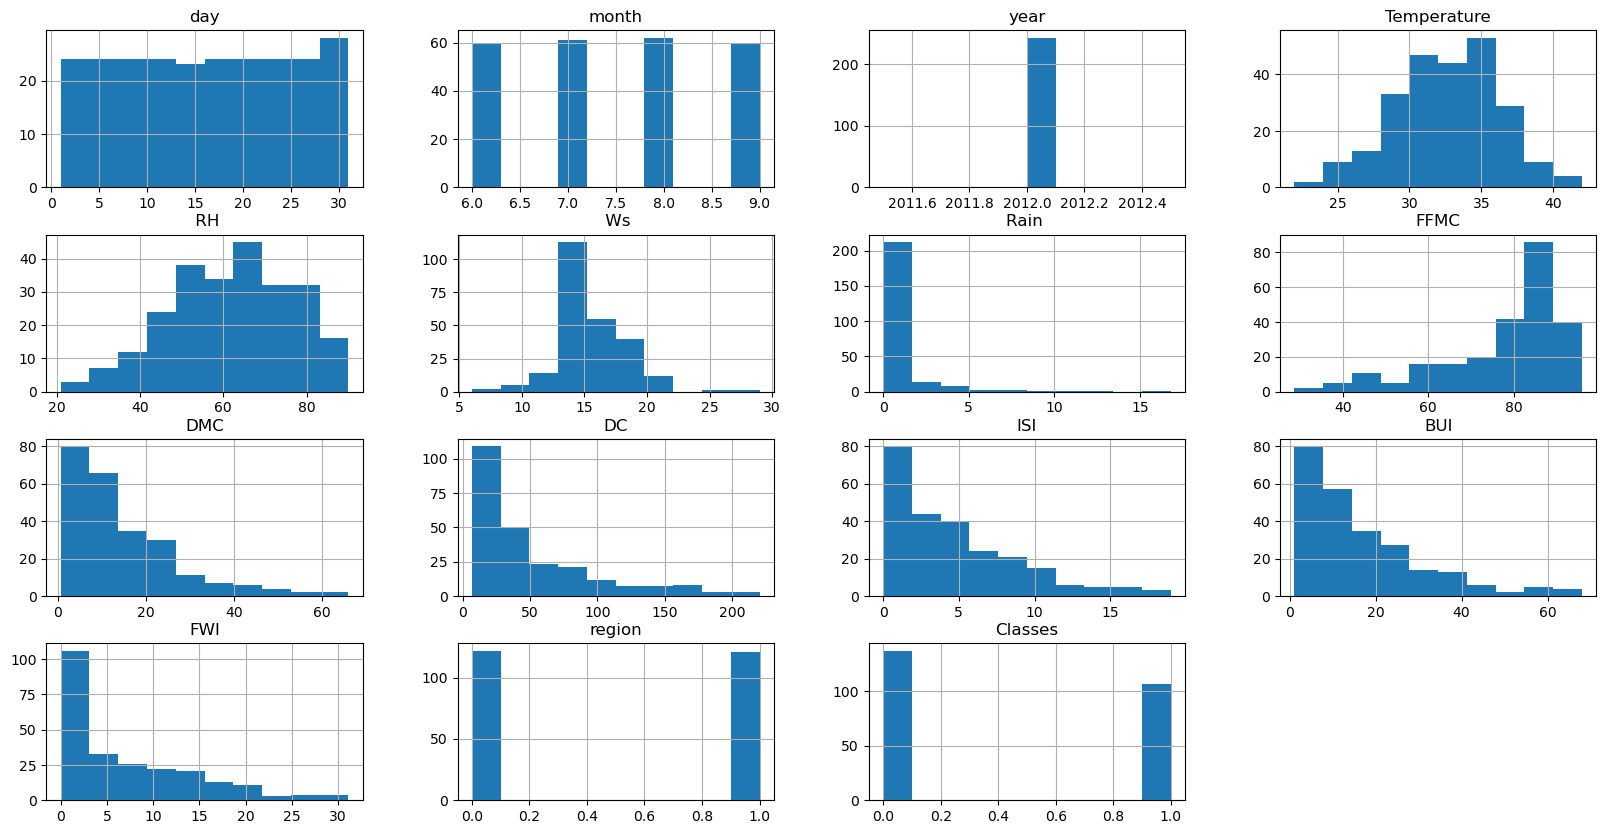

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of attributes
df.hist(figsize=(20, 10))
plt.show()

##Some of these attributes were not normally distributed as things such as Fine Fuel Moisture Code,
#Duff Moisture Code, Drought Code, Initial Spread Index, Buildup Index, and Fire Weather Index. 
#We see that the majority of these are skewed right. The reason is that often these codes and indexes will tend to 
#indicate greater levels of danger and extremity as the index increases. It would be unreasonable to assume that a 
#certain location is always under imminent danger with a high index/code for 4 months which is why the data will be 
#right skewed with most of the indexes being towards lower index/code values.

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Separate features and target variable
X = df.drop('Classes', axis=1)
y = df['Classes']

# Standardize features
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['Classes'] = y.reset_index(drop=True)

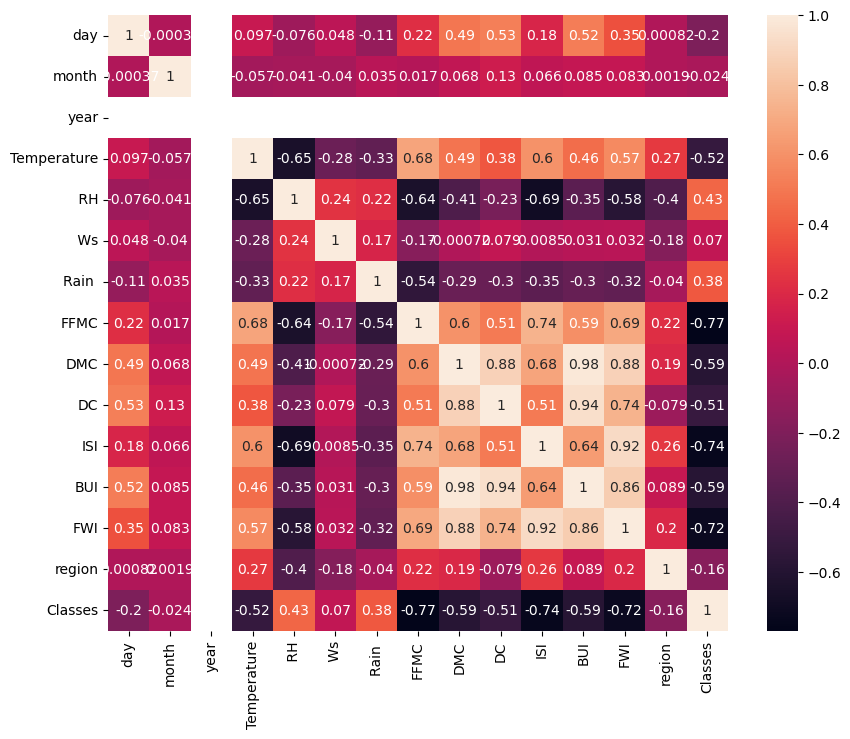

In [11]:
# Correlation matrix to understand correlation between fires and other variables
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [12]:
features = ['Temperature',' RH','Rain ','FFMC','DMC','DC','ISI','BUI','FWI'] 
#abs value > .3 is what I used to determine if I wwanted to include it

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_scaled[features]
y = df_scaled['Classes']

# Splitting and training the data. I chose 80/20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Model Construction

In [14]:
from sklearn.model_selection import GridSearchCV
sgd = SGDRegressor()

#parameter grid
param_grid = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'max_iter': [1000, 2000, 3000]
}

#GridSearchCV
grid_search = GridSearchCV(sgd, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_search.best_params_
best_sgd = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\Hasan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hasan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hasan\anaconda3\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Hasan\anaconda3\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Hasan\anaconda3\lib\site-packa

In [15]:
# Predicting based on the tuned hyperparameters
y_train_pred = best_sgd.predict(X_train)
y_test_pred = best_sgd.predict(X_test)

# metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

Training MSE: 0.07082077916984676
Test MSE: 0.09731878287409432
Training R^2: 0.7097766937242648
Test R^2: 0.610562670532166


In [16]:
import statsmodels.api as sm

#training the model
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [17]:
# fitting the model 
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Classes   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     52.87
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           2.15e-46
Time:                        19:46:31   Log-Likelihood:                -14.588
No. Observations:                 194   AIC:                             49.18
Df Residuals:                     184   BIC:                             81.85
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4219      0.019     21.857      